<center><image src="https://drive.google.com/uc?id=1n3G4TdK_u6PQHcLrxB_A0HijNdigXmUH">

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Домашнее задание можно разделить на следующие части:

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]
* Мир других лоссов! [2]
  * Dice Loss [1]
  * Focal Loss [1]
  * BONUS: лосс из статьи [5]
* Новая модель! [2]
  * UNet [2]


**Максимальный балл:** 10 баллов.

Также для студентов желающих еще более углубиться в задачу предлагается решить бонусное задание, которое даст дополнительные 5 баллов. BONUS задание необязательное.


# Загрузка данных

1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>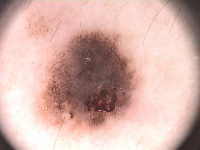</td><td>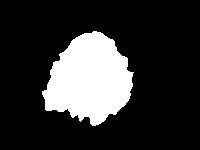</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [1]:
# !gdown 1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql

In [2]:
# get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [4]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [5]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

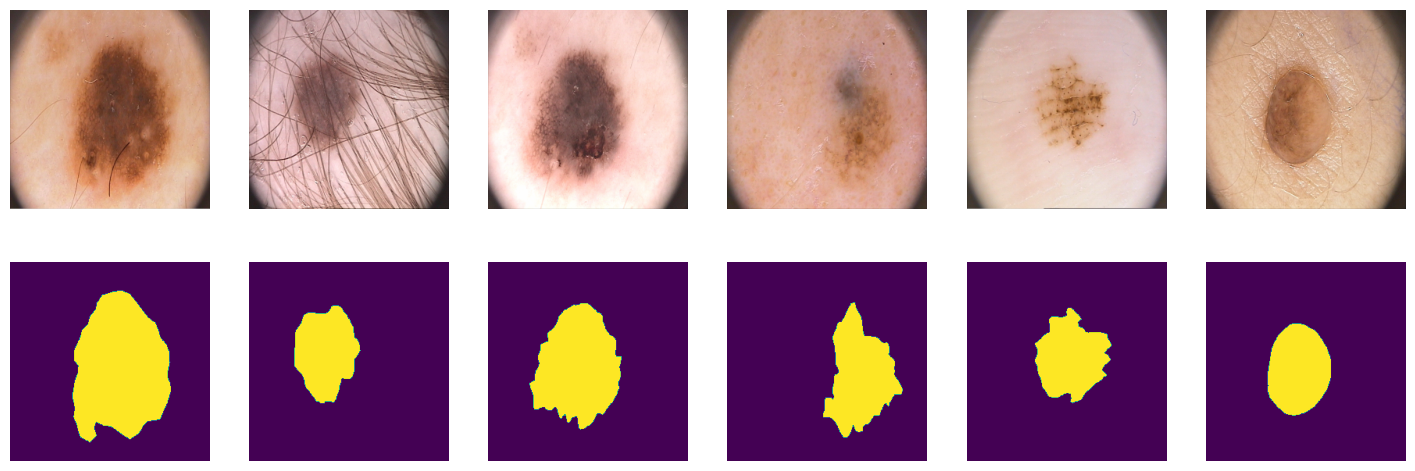

In [6]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [7]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [8]:
print(len(tr), len(val), len(ts))

100 50 50


## PyTorch DataLoader

In [9]:
from torch.utils.data import DataLoader
batch_size = 25
train_dataloader = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [10]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# device = torch.device("cpu")

cuda


In [63]:
# Дополнительные методы для очистки памяти после обучения модели
import gc

# Удалить неиспользуемые объекты
def clear_memory():
    # Удалить ссылки на объекты
    gc.collect()
    
    # Очистить память на GPU
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()

# Вызов функции очистки
clear_memory()

# Метрика

## IoU (intersection over union)

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Что будет являться пересением и объединением в задаче сегментации?

Давайте разберем следующий пример:





<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1rBYFgli48AUUN9idiyq8j3J5DboB93yN" width=1000 height=800/></p>

In [ ]:
!pip install torchmetrics

In [12]:
from torchmetrics import JaccardIndex

iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)

# Построй свой первый бейзлайн!

Итак, загрузка файлов, код датасета и даталоадера написана за вас. Метрика IoU написана за вас! Вам остается написать лосс, модель и функции обучения и теста модели.

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]

## BCE Loss [2 балла]

Популярным лоссом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

### Вывод численно стабильной формулы BCE лосса [1 балл]



Выведите из формулы [1] формулу [2]:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

Не забываем, что здесь $\hat y_i$ - это логиты сети, не вероятности и не лейблы.

**Ответ:**

### Реализуйте в коде оба варианта лосса [1 балл]

Реализуйте следующие функции:

*   `bce_true()` - честная прямая реализация лосса с формулой $$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$
*   `bce_loss()` - реализация формулы, которую мы вывели $$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

И сравните результаты функций с реализацией Pytorch:
*   `bce_torch()`
*   `bce_torch_with_logits()`

In [13]:
import torch.nn.functional as F
import torch.nn as nn

In [14]:
bce_torch = nn.BCELoss(reduction='sum') # (sigmoid(y_pred), y_real)
bce_torch_with_logits = nn.BCEWithLogitsLoss(reduction='sum')

In [15]:
# Аналогичная реализация вручную (без использования встроенной функции)
def bce_true(y_pred, y_real):
    sigmoid_pred = torch.sigmoid(y_pred)
    # Вычисление потерь по формуле BCE
    loss = -(torch.mul(y_real, torch.log(sigmoid_pred)) + torch.mul((1 - y_real), torch.log(1 - sigmoid_pred)))
    # Возвращаем среднее значение потерь
    return torch.sum(loss)


# Функция потерь - бинарная кросс-энтропия с использованием сигмоиды
def bce_loss(y_pred, y_real):
    # Вычисление бинарной кросс-энтропии
    loss = y_pred - torch.mul(y_real, y_pred) + torch.log(1 + torch.exp(-1*y_pred))
    # Возвращаем среднее значение потерь
    return torch.sum(loss)

Проверим корректность работы на простом примере

In [16]:
y_pred = torch.randn(3, 2, requires_grad=False)
y_true = torch.rand(3, 2, requires_grad=False)

print(f'BCE loss from scratch bce_loss = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch = {bce_torch(torch.sigmoid(y_pred), y_true)}')
print(f'BCE loss from torch with logits bce_torch = {bce_torch_with_logits(y_pred, y_true)}')


BCE loss from scratch bce_loss = 4.218503952026367
BCE loss честно посчитанный = 4.218503952026367
BCE loss from torch bce_torch = 4.218503952026367
BCE loss from torch with logits bce_torch = 4.218503952026367


Инструкции `assert` в Python — это булевы выражения, которые проверяют, является ли условие истинным (`True`). Внизу в коде мы проверяем функция `bce_loss()` выдает тот же результат, что и функция из Pytorch или нет. Если равенства не будет, что будет означать, что результаты функций не совпадают, а значит вы неправильно реализовали фукнцию `bce_loss()`, `assert` возвратит ошибку.

Функция `numpy.isclose()` используется для сравнения двух чисел с учётом допустимой погрешности. Она особенно полезна при работе с числами с плавающей точкой, где точное сравнение может быть проблематичным из-за ограничений представления таких чисел в компьютере.

Как она работает?

`numpy.isclose(a, b, rtol=1e-05, atol=1e-08) `принимает два числа (`a` и `b`) и сравнивает их, учитывая относительную и абсолютную погрешность. Если разница между двумя числами меньше заданного порога, функция возвращает `True`, иначе — `False`.

Параметры:

    rtol: Относительная погрешность (по умолчанию 1e-05). Используется для определения разницы относительно большего значения.
    atol: Абсолютная погрешность (по умолчанию 1e-08). Определяет минимальную разницу, которую следует учитывать.

Мы будем использовать `assert` и `numpy.isclose()` для проверки корректности нашего кода.

In [17]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))

Давайте теперь посчитаем на простом примере, но с теми же размерностями, что и в датасете

In [18]:
y_pred = torch.randn((2, 1, 3, 3), requires_grad=False)
y_true = torch.randint(0, 2, (2, 1, 3, 3))

print(f'BCE loss from scratch bce_loss = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch = {bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float))}')
print(f'BCE loss from torch with logits bce_torch = {bce_torch_with_logits(y_pred, y_true.to(torch.float))}')

BCE loss from scratch bce_loss = 14.548480987548828
BCE loss честно посчитанный = 14.548481941223145
BCE loss from torch bce_torch = 14.548481941223145
BCE loss from torch with logits bce_torch = 14.548480987548828


In [19]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))

Давайте посчитаем на реальных логитах и сегментационной маске:

In [20]:
!gdown --folder 1EX0RW1TRQVkLmR1h6miCQqyhYPFyg28M

/bin/bash: line 1: gdown: command not found


In [21]:
path_to_dummy_samples = 'for_asserts'
dummpy_sample = {'logits': torch.load(f'{path_to_dummy_samples}/logits.pt'),
                 'labels': torch.load(f'{path_to_dummy_samples}/labels.pt')}
dummpy_sample['labels'] = dummpy_sample['labels'].to(device)
dummpy_sample['logits'] = dummpy_sample['logits'].to(device)

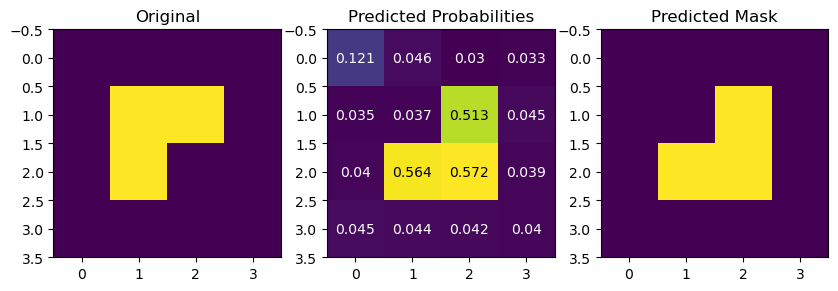

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize= (10,3*10))

ax1.imshow(dummpy_sample['labels'].squeeze(1)[0].cpu())
ax1.set_title("Original")

ax2.imshow(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu())
for (j,i),label in np.ndenumerate(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu()):
    if label < 0.5:
        color = 'white'
    else:
        color = 'black'
    ax2.text(i,j,round(label,3), color=color, ha='center',va='center')

ax2.set_title("Predicted Probabilities")

ax3.imshow((dummpy_sample['logits'].sigmoid() > 0.5).squeeze(1)[0].cpu())
ax3.set_title("Predicted Mask")
plt.show()

Проверяем на данном примере:

In [23]:
bce_loss_score = bce_loss(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_true_score = bce_true(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_torch_score = bce_torch(torch.sigmoid(dummpy_sample['logits'].cpu()), dummpy_sample['labels'].cpu().float())
bce_torch_with_logits_score = bce_torch_with_logits(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu().float())
assert np.isclose(bce_loss_score, bce_torch_score)
assert np.isclose(bce_loss_score, bce_torch_with_logits_score)
assert np.isclose(bce_true_score, bce_torch_score)
assert np.isclose(bce_true_score, bce_torch_with_logits_score)

## SegNet [2 балла]

Ваше задание здесь состоит в том, чтобы реализовать SegNet архитектуру.

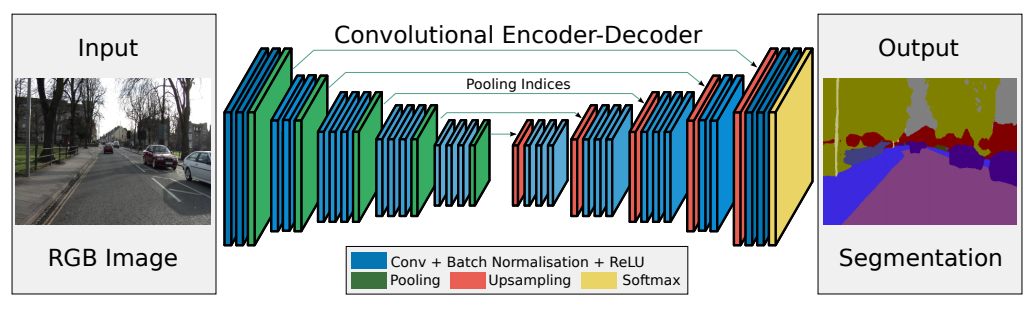

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

# Реализация SegNet

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

Хорошие ресурсы по SegNet архитектуре:
1. https://medium.com/@nikdenof/segnet-from-scratch-using-pytorch-3fe9b4527239


In [25]:
class ConvReLU(nn.Module):
    def __init__(self, in_c, out_c, kernel_size=3, padding=1) -> None:
        super(ConvReLU, self).__init__()
        self.conv = nn.Conv2d(in_c, out_c, kernel_size=kernel_size, padding=padding)
        self.bn = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class EncoderBlock(nn.Module):
    def __init__(self, in_c, out_c, depth=2, kernel_size=3, padding=1) -> None:
        super(EncoderBlock, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(depth):
            self.layers.append(ConvReLU(in_c if i == 0 else out_c, out_c, kernel_size, padding))
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x, ind = self.pool(x)
        return x, ind

class DecoderBlock(nn.Module):
    def __init__(self, in_c, out_c, depth=2, kernel_size=3, padding=1, classification=False) -> None:
        super(DecoderBlock, self).__init__()
        self.unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.layers = nn.ModuleList()
        for i in range(depth):
            if i == depth - 1 and classification:
                self.layers.append(nn.Conv2d(in_c, out_c, kernel_size=kernel_size, padding=padding))
            elif i == depth - 1:
                self.layers.append(ConvReLU(in_c, out_c, kernel_size=kernel_size, padding=padding))
            else:
                self.layers.append(ConvReLU(in_c, in_c, kernel_size=kernel_size, padding=padding))

    def forward(self, x, ind):
        x = self.unpool(x, ind)
        for layer in self.layers:
            x = layer(x)
        return x

class SegNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, feauters=64):
        super(SegNet, self).__init__()
    
        # VGG-16 architecture
        self.enc0 = EncoderBlock(in_c=in_channels, out_c=feauters)
        self.enc1 = EncoderBlock(in_c=feauters, out_c=feauters*2)
        self.enc2 = EncoderBlock(in_c=feauters*2, out_c=feauters*4, depth=3)
        self.enc3 = EncoderBlock(in_c=feauters*4, out_c=feauters*8, depth=3)
        
        # bottleneck
        self.b1_enc = EncoderBlock(in_c=feauters*8, out_c=feauters*8, depth=3)
        self.b1_dec = DecoderBlock(in_c=feauters*8, out_c=feauters*8, depth=3)

        # decoder (upsampling)
        self.dec3 = DecoderBlock(in_c=feauters*8, out_c=feauters*4, depth=3)
        self.dec2 = DecoderBlock(in_c=feauters*4, out_c=feauters*2, depth=3)
        self.dec1 = DecoderBlock(in_c=feauters*2, out_c=feauters)
        self.dec0 = DecoderBlock(in_c=feauters, out_c=out_channels, classification=True)

    def forward(self, x):
        # encoder
        e0, ind0 = self.enc0(x)
        e1, ind1 = self.enc1(e0)
        e2, ind2 = self.enc2(e1)
        e3, ind3 = self.enc3(e2)

        # bottleneck
        b1_e, b1_ind = self.b1_enc(e3)
        b2_d = self.b1_dec(b1_e, b1_ind)

        # decoder
        d3 = self.dec3(b2_d, ind3)
        d2 = self.dec2(d3, ind2)
        d1 = self.dec1(d2, ind1)
        output = self.dec0(d1, ind0)

        return output

## Тренировка [1 балл]

Напишите функцию для обучения модели.

In [26]:
from tqdm.notebook import tqdm

In [27]:
def train(model, opt, loss_fn, epochs, data_train, data_val, model_name):
    best_loss = 1000
    
    train_loss = []
    val_loss = []

    train_jaccard = []
    val_jaccard = []
    
    for epoch in range(epochs):
        train_batch_loss = []
        train_batch_jaccard = []
        model.train()  # режим обучения
        
        for i, (X_batch, Y_batch) in enumerate(data_train):
            # переносим батч на GPU
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)

            Y_pred = model(X_batch)
            Y_batch = Y_batch.float()
            
            loss = loss_fn(Y_pred, Y_batch)
            # добавляем лосс на батче в список лоссов
            train_batch_loss.append(loss)
            
            loss.backward()
            opt.step()  
            opt.zero_grad()
            
            # добавляем метрику Жаккарда в список
            train_batch_jaccard.append(iou_score(Y_pred, Y_batch))

            del X_batch
            del Y_batch
        
        train_loss.append(float(sum(train_batch_loss)/len(train_batch_loss)))
        train_jaccard.append(float(sum(train_batch_jaccard)/len(train_batch_jaccard)))

        # Считаем аналогичные метрики на валидационном датасете
        val_batch_loss = []
        val_batch_jaccard = []
        model.eval() # режим инференса
        
        for i, (X_batch, Y_batch) in enumerate(data_val):
            # переносим батч на GPU
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
    
            Y_pred = model(X_batch)
            Y_batch = Y_batch.float()
            
            loss = loss_fn(Y_pred, Y_batch)
            # добавляем лосс на батче в список лоссов
            val_batch_loss.append(loss)
            
            # добавляем метрику Жаккарда в список
            val_batch_jaccard.append(iou_score(Y_pred, Y_batch))

            del X_batch
            del Y_batch
        
        val_loss.append(float(sum(val_batch_loss)/len(val_batch_loss)))
        val_jaccard.append(float(sum(val_batch_jaccard)/len(val_batch_jaccard)))

        # Сохраняем лучшую модель
        best_val_jaccard = -1
        if val_jaccard[-1] > best_val_jaccard:
            best_val_jaccard = val_jaccard[-1]
            torch.save(model.state_dict(), f'{model_name}.pth')
    
    return {'train_loss': train_loss, 'val_loss': val_loss, 'train_jaccard': train_jaccard, 'val_jaccard': val_jaccard}

Обучите модель **SegNet**. В качестве оптимайзера можно взять Adam.

## Инференс [1 балл]

После обучения модели напишите фукнцию теста, воспользуйтесь лучшим чекпоинтом и протестируйте работу модели на тестовой выборке.

In [28]:
def test(model, data_test, loss_fn, device):
    model.to(device)
    model.eval() # переводим модель в режим инференса

    test_loss = []
    test_jaccard = []

    for i, (X_batch, Y_batch) in enumerate(data_test):
        # переносим батч на GPU
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)

        Y_pred = model(X_batch)
        Y_batch = Y_batch.float()
        
        loss = loss_fn(Y_pred, Y_batch)
        # добавляем лосс на батче в список лоссов
        test_loss.append(loss)
        
        # добавляем метрику Жаккарда в список
        test_jaccard.append(iou_score(Y_pred, Y_batch))

        del X_batch
        del Y_batch

    return {"test_loss": float(sum(test_loss)/len(test_loss)), "test_jaccard": float(sum(test_jaccard)/len(test_jaccard))}

In [89]:
def show_random_images(model, data, device):
    # Отображаем случайные 6 картинок
    # получаем один батч из data_test
    X, Y = next(iter(data))
    
    # получаем ответ сети на картинки из батча
    Y_pred = model(X.to(device))
    Y_hat = Y_pred.detach().cpu().numpy() 
    Y_hat = np.argmax(Y_hat, axis=1)

    clear_output(wait=True)
    _, axes = plt.subplots(3, 6, figsize=(18, 12))
    
    for k in range(6):
        # Отображаем входные изображения
        axes[0][k].imshow(np.rollaxis(X[k].cpu().numpy(), 0, 3), cmap='gray', aspect='auto')
        axes[0][k].title.set_text('Input')
        
        # Отображаем реальные маски сегментации
        axes[1][k].imshow(Y[k].squeeze().cpu().numpy(), cmap='gray', aspect='auto')  # Убираем лишнее измерение
        axes[1][k].title.set_text('Real Map')
        
        # Отображаем предсказанные маски сегментации
        pred_mask = (torch.sigmoid(Y_pred[k]) > 0.5).cpu().numpy() if Y_pred.shape[1] == 1 else np.argmax(Y_pred[k].cpu().numpy(), axis=0)
        axes[2][k].imshow(pred_mask.squeeze(), cmap='gray', aspect='auto')  # Убираем лишнее измерение
        axes[2][k].title.set_text('Predicted Map')
    
    plt.show()

# SegNet BCE Loss

In [65]:
# Обучение модели и сохранение лучшего чекпоинта
segnet_model = SegNet().to(device)
opt = torch.optim.Adam(segnet_model.parameters(), lr=1e-3)
segnet_bce_loss_train_results = train(segnet_model, opt, bce_loss, 40, train_dataloader, valid_dataloader, 'seg_net_model_bce_loss')
del segnet_model

# Загрузка лучшего чекпоинта модели
segnet_model = SegNet().to(device)
# Загрузка весов
segnet_model.load_state_dict(torch.load("seg_net_model_bce_loss.pth"))
segnet_bce_loss_test_results = test(segnet_model, test_dataloader, dice_loss, device)

del segnet_model
clear_memory()

# Мир других лоссов!

## Дополнительные функции потерь [2 балла]

В данном разделе вам потребуется имплементировать две функции потерь: DICE и Focal loss.


### Dice Loss

**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

В терминах матрицы ошибок она будет считаться следующим образом:

$$D(X,Y) = \frac{2TP}{2TP + FP + FN}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1- D(X, Y)$$

**Hints** (!):

1. Не забудьте подумать о численной нестабильности, возникающей в математической формуле при ситуации, когда $\frac{0}{0}$, т.е. вам нужно добавить очень маленькое число, например $\epsilon = 1e^{-8}$, в обе части дроби при подсчете $D(X,Y)$:

$$D(X,Y) = \frac{2TP + ϵ}{2TP + FP + FN + ϵ}$$

2. Dice метрика(!), не лосс, считается похожим образом как IoU:

    2.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    2.2. Фиксируем порог, например threshold=0.5, и всему что ниже порога ставим значение 0, всему что выше 1. Получаем предсказанную маску из 0 и 1.

    2.3. Считаем TP, FP, FN

    2.4. Считаем DICE метрику по формуле

Вы можете прописать для себя функцию `dice_score()` и сравнить с результатами работы функции из библиотеки `torchmetrics`.

3. Но с метрикой есть проблема, что она не дифференцируема, и если вы захотите просто взять и прописать `dice_loss` = 1 - `dice_score`, Pytorch поругается на вас и скажет, что это недифференцируемая метрика. Чтобы посчитать dice_loss делаем следующие шаги:

    3.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    3.2. Здесь нам уже не нужно фиксировать порог, мы просто работаем с вероятностями. Значения вероятностей дифференцируемы и через них будут протекать градиенты.

    3.3. Считаем TP, FP, FN также как и в Dice метрике, только вместо маски, подаем вероятности.

    3.4. Считаем DICE метрику по формуле

    3.5. Считаем лосс как Loss = 1 - DICE

Итак, давайте сначала пропишем dice_score.

In [32]:
def dice_score(logits: torch.Tensor, labels: torch.Tensor, threshold: float = 0.5):
    '''
    Это именно метрика, не лосс.
    '''
    eps = 10**(-8)
    
    predicted = (torch.sigmoid(logits) > threshold).float()
    TP = torch.sum(predicted * labels)
    FP = torch.sum(predicted * (1 - labels))
    FN = torch.sum((1 - predicted) * labels)

    score = (2*TP + eps) / (2*TP + FP + FN + eps)
    return score

In [33]:
dice_score(dummpy_sample['logits'], dummpy_sample['labels'])

tensor(0.6667, device='cuda:0')

Проверим на корректность функцию dice_score:

In [34]:
from torchmetrics.classification import Dice

dice = Dice(average='micro').to(device)
dice(dummpy_sample['logits'].sigmoid(), dummpy_sample['labels'].to(int))

tensor(0.6667, device='cuda:0')

In [35]:
assert dice(dummpy_sample['logits'].sigmoid(), dummpy_sample['labels'].to(int)) == dice_score(dummpy_sample['logits'], dummpy_sample['labels'])

Давайте теперь пропишем лосс и воспользуемся библиотекой `segmentation-models-pytorch`, чтобы убедиться в корректности нашей функции.

In [36]:
def dice_loss(logits: torch.Tensor, labels: torch.Tensor):
    '''
    Это лосс.
    '''
    eps = 10**(-8)
    predicted = torch.sigmoid(logits)
    TP = torch.sum(predicted * labels)
    FP = torch.sum(predicted * (1 - labels))
    FN = torch.sum((1 - predicted) * labels)

    score = (2*TP + eps) / (2*TP + FP + FN + eps)
    return 1 - score

Проверка на корректность:

In [37]:
from segmentation_models_pytorch.losses import DiceLoss
dice_loss_torch = DiceLoss(mode='binary')
dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'])

tensor(0.5756, device='cuda:0')

In [38]:
assert dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'].to(int)) == dice_loss(dummpy_sample['logits'], dummpy_sample['labels'])

## Focal Loss

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.


Из оригинальной статьи по [Focal Loss](https://arxiv.org/pdf/1708.02002.pdf):

$$p_t = \sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)$$

$$\mathcal L_{focal}(y, \hat y) = (1 - p_t)^{\gamma} \mathcal L_{BCE}(y_i, \hat y_i).$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - p_t)^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - (\sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)))^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

In [39]:
import torch.nn.functional as F

def focal_loss(y_pred, y_real, eps = 1e-8, gamma = 2):
    p = torch.sigmoid(y_pred)
    
    ce_loss = F.binary_cross_entropy_with_logits(y_pred, y_real, reduction="none")

    p_t = p * y_real + (1 - p) * (1 - y_real)
    loss = ce_loss * ((1 - p_t) ** gamma)
    
    return loss.sum()

Проверка корректности функции:

In [40]:
from torchvision.ops import sigmoid_focal_loss
sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='sum')

tensor(3.6161, device='cuda:0')

In [41]:
assert sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='sum') == focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], gamma=2.0)

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее, и провести численное сравнение с предыдущими функциями.

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

In [42]:
import torch.nn.functional as F

def compute_sdf(labels: torch.Tensor, pred_shape: torch.Size) -> torch.Tensor:
    """
    Вычисляет Signed Distance Map (SDM) для истинной маски.
    
    Args:
        labels (torch.Tensor): Истинные маски сегментации (binary tensor).
        pred_shape (torch.Size): Размерность предсказанной маски.
    
    Returns:
        torch.Tensor: Signed Distance Map с тем же размером, что и предсказания.
    """
    # Переводим в numpy для работы с расстояниями
    from scipy.ndimage import distance_transform_edt, distance_transform_cdt

    # Подготавливаем SDM для каждой маски в батче
    labels_np = labels.cpu().numpy()
    sdf = np.zeros_like(labels_np, dtype=np.float32)

    for b in range(labels_np.shape[0]):  # Для каждого примера в батче
        pos_mask = labels_np[b].astype(bool)  # Положительный класс
        neg_mask = ~pos_mask

        sdf[b] = distance_transform_edt(pos_mask) - distance_transform_edt(neg_mask)

    return torch.tensor(sdf, dtype=torch.float32, device=labels.device)

def boundary_loss(pred: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
    """
    Реализация Boundary Loss.
    
    Args:
        pred (torch.Tensor): Логиты предсказаний модели.
        labels (torch.Tensor): Истинные метки сегментации.
    
    Returns:
        torch.Tensor: Скалярное значение Boundary Loss.
    """
    # Применяем сигмоиду, если предсказания — это логиты
    pred_probs = torch.sigmoid(pred)

    # Вычисляем SDM для истинных масок
    sdf = compute_sdf(labels, pred.shape)

    # Умножаем вероятности на SDF
    boundary_loss = torch.mean((sdf * (pred_probs - labels)) ** 2)
    
    return boundary_loss

## Обучите SegNet на новых лоссах

**Задание**: обучите SegNet на новых лоссах и сравните все три лосса:
*   При каком лоссе модель сходится быстрее?
*   При каком лоссе модель выдает наилучшую метрику?

Напишите развернутый ответ на вопросы.



# SegNet Dice Loss

In [66]:
# Обучение модели и сохранение лучшего чекпоинта
segnet_model = SegNet().to(device)
opt = torch.optim.Adam(segnet_model.parameters(), lr=1e-3)
segnet_dice_loss_train_results = train(segnet_model, opt, dice_loss, 40, train_dataloader, valid_dataloader, 'seg_net_dice_loss')

# Загрузка лучшего чекпоинта модели
segnet_model = SegNet()
# Загрузка весов
segnet_model.load_state_dict(torch.load("seg_net_dice_loss.pth"))
segnet_dice_loss_test_results = test(segnet_model, test_dataloader, dice_loss, device)

del segnet_model
clear_memory()

# SegNet Focal Loss

In [67]:
# Обучение модели и сохранение лучшего чекпоинта
segnet_model = SegNet().to(device)
opt = torch.optim.Adam(segnet_model.parameters(), lr=1e-3)
segnet_focal_loss_train_results = train(segnet_model, opt, focal_loss, 40, train_dataloader, valid_dataloader, 'seg_net_focal_loss')

# Загрузка лучшего чекпоинта модели
segnet_model = SegNet().to(device)
# Загрузка весов
segnet_model.load_state_dict(torch.load("seg_net_focal_loss.pth"))
segnet_focal_loss_test_results = test(segnet_model, test_dataloader, focal_loss, device)

del segnet_model
clear_memory()

# SegNet Boundary Loss

In [68]:
# Boundary loss
segnet_model = SegNet().to(device)
opt = torch.optim.Adam(segnet_model.parameters(), lr=1e-3)
segnet_boundary_loss_train_results = train(segnet_model, opt, boundary_loss, 40, train_dataloader, valid_dataloader, 'seg_net_boundary_loss')

# Загрузка лучшего чекпоинта модели
segnet_model = SegNet()
# Загрузка весов
segnet_model.load_state_dict(torch.load("seg_net_boundary_loss.pth"))
segnet_boundary_loss_test_results = test(segnet_model, test_dataloader, boundary_loss, device)

del segnet_model
clear_memory()

# Новая модель!

## U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

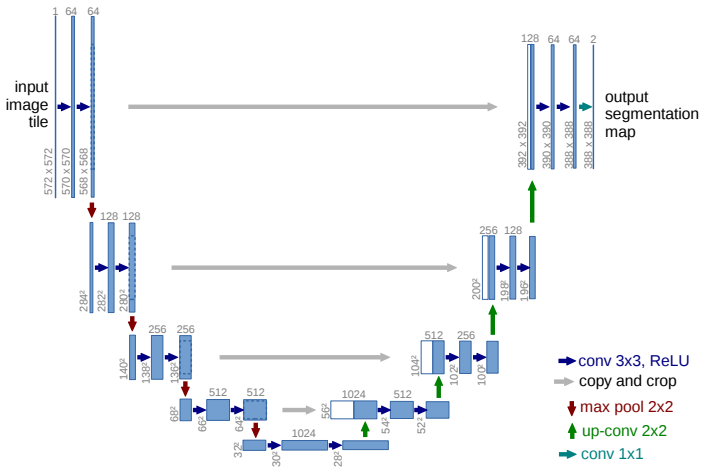

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

## Обучите UNet

Задание: обучите UNet на всех трех лоссах: BCE, Dice, Focal и сравните результаты с SegNet:
*   Какая модель дает лучшие значения по метрике?
*   Какая модель дает лучшие значения по лоссам?
*   Какая модель обучается быстрее?
*   Сравните визуально результаты SegNet и UNet.

Напишите развернутый ответ на вопросы.



In [55]:
import torch.nn.functional as F
import torch.nn as nn

In [56]:
class UNet(nn.Module):
    def __init__(self, n_class=1):
        super().__init__()

        # Encoder block 1
        self.encoder_1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        
        # Encoder block 2
        self.encoder_2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        # Encoder block 3
        self.encoder_3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        # Encoder block 4
        self.encoder_4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.encoder_max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # bottleneck block
        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU()
        )

        # Decoder block
        self.upscale_4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder_4 = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.upscale_3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder_3 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.upscale_2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder_2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.upscale_1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder_1 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=1)
        )
        
    def forward(self, x):
        # Encoders
        enc_1 = self.encoder_1(x)
        max_pool_1 = self.encoder_max_pool(enc_1)
        
        enc_2 = self.encoder_2(max_pool_1)
        max_pool_2 = self.encoder_max_pool(enc_2)
        
        enc_3 = self.encoder_3(max_pool_2)
        max_pool_3 = self.encoder_max_pool(enc_3)
        
        enc_4 = self.encoder_4(max_pool_3)
        max_pool_4 = self.encoder_max_pool(enc_4)

        # bottleneck
        bottleneck = self.bottleneck(max_pool_4)
        

        # Decoders
        cat_4 = torch.cat((enc_4, self.upscale_4(bottleneck)), dim=1)
        dec_4 = self.decoder_4(cat_4)

        cat_3 = torch.cat((enc_3, self.upscale_3(dec_4)), dim=1)
        dec_3 = self.decoder_3(cat_3)

        cat_2 = torch.cat((enc_2, self.upscale_2(dec_3)), dim=1)
        dec_2 = self.decoder_2(cat_2)
        
        cat_1 = torch.cat((enc_1, self.upscale_1(dec_2)), dim=1)
        output = self.decoder_1(cat_1)
        
        return output

# U-Net Binary Cross Entropy

In [69]:
# BCE U-Net
unet_model = UNet().to(device)
opt = torch.optim.Adam(unet_model.parameters(), lr=1e-3)
unet_bce_loss_train_results = train(unet_model, opt, bce_loss, 40, train_dataloader, valid_dataloader, 'u_net_model_bce_loss')

# Загрузка лучшего чекпоинта модели
unet_model = UNet().to(device)
# Загрузка весов
unet_model.load_state_dict(torch.load("u_net_model_bce_loss.pth"))
unet_bce_loss_test_results = test(unet_model, test_dataloader, bce_loss, device)

del unet_model
clear_memory()

# U-Net Dice Loss

In [70]:
# U-net and Dice loss
unet_model = UNet().to(device)
opt = torch.optim.Adam(unet_model.parameters(), lr=1e-3)
unet_dice_loss_train_results = train(unet_model, opt, dice_loss, 40, train_dataloader, valid_dataloader, 'u_net_model_dice_loss')

# Загрузка архитектуры модели
unet_model = UNet().to(device)
# Загрузка весов
unet_model.load_state_dict(torch.load("u_net_model_dice_loss.pth"))
unet_dice_loss_test_results = test(unet_model, test_dataloader, dice_loss, device)

del unet_model
clear_memory()

# U-net Focal Loss

In [71]:
# U-net and Focal Loss
unet_model = UNet().to(device)
opt = torch.optim.Adam(unet_model.parameters(), lr=1e-3)
unet_focal_loss_train_results = train(unet_model, opt, focal_loss, 40, train_dataloader, valid_dataloader, 'u_net_model_focal_loss')

# Загрузка архитектуры модели
unet_model = UNet().to(device)
# Загрузка весов
unet_model.load_state_dict(torch.load("u_net_model_focal_loss.pth"))
unet_focal_loss_test_results = test(unet_model, test_dataloader, focal_loss, device)

del unet_model
clear_memory()

# U-net Boundary Loss

In [75]:
# U-net and Focal Loss
unet_model = UNet().to(device)
opt = torch.optim.Adam(unet_model.parameters(), lr=1e-3)
unet_boundary_loss_train_results = train(unet_model, opt, boundary_loss, 40, train_dataloader, valid_dataloader, 'u_net_model_boundary_loss')

# Загрузка архитектуры модели
unet_model = UNet().to(device)
# Загрузка весов
unet_model.load_state_dict(torch.load("u_net_model_boundary_loss.pth"))
unet_boundary_loss_test_results = test(unet_model, test_dataloader, boundary_loss, device)

del unet_model
clear_memory()

# Вывод

Были обучены 2 нейронные сети SegNet, а также U-Net. Также были использованые 4 различных типа loss функций, а именно Binary Cross Entropy Loss, Dice Loss, Focal Loss и Boundary Loss. В качестве ключевой метрики использовалась мера Жаккара, которая вычислялась только на тестовой выборке. Были получены следующие результаты:  
  
**SegNet:**  
    - **BCE Loss:** 0.7068  
    - **Dice Loss:** 0.7286  
    - **Focal Loss:** 0.6832     
    - **Boundary Loss:** 0.619    
**U-Net:**  
    - **BCE Loss:** 0.774       
    - **Dice Loss:** 0.6977   
    - **Focal Loss:** 0.6635     
    - **Boundary Loss:** 0.6817    

Лучшее качество было достигнуто на модели U-net с использование Focal Loss. В среднем качество на модели U-net было почти всегда выше, чем на модели SegNet, это может объясняться тем, что данная архитектура была специально разработана для задачи сегментации медицинских снимков.

С точки зрения устойчивости обучения, сеть U-net на всех Loss функция показывает более стабильную и гладкую сходимость, чем сеть SegNet. Ниже представлены графики сходимостей Loss функций.

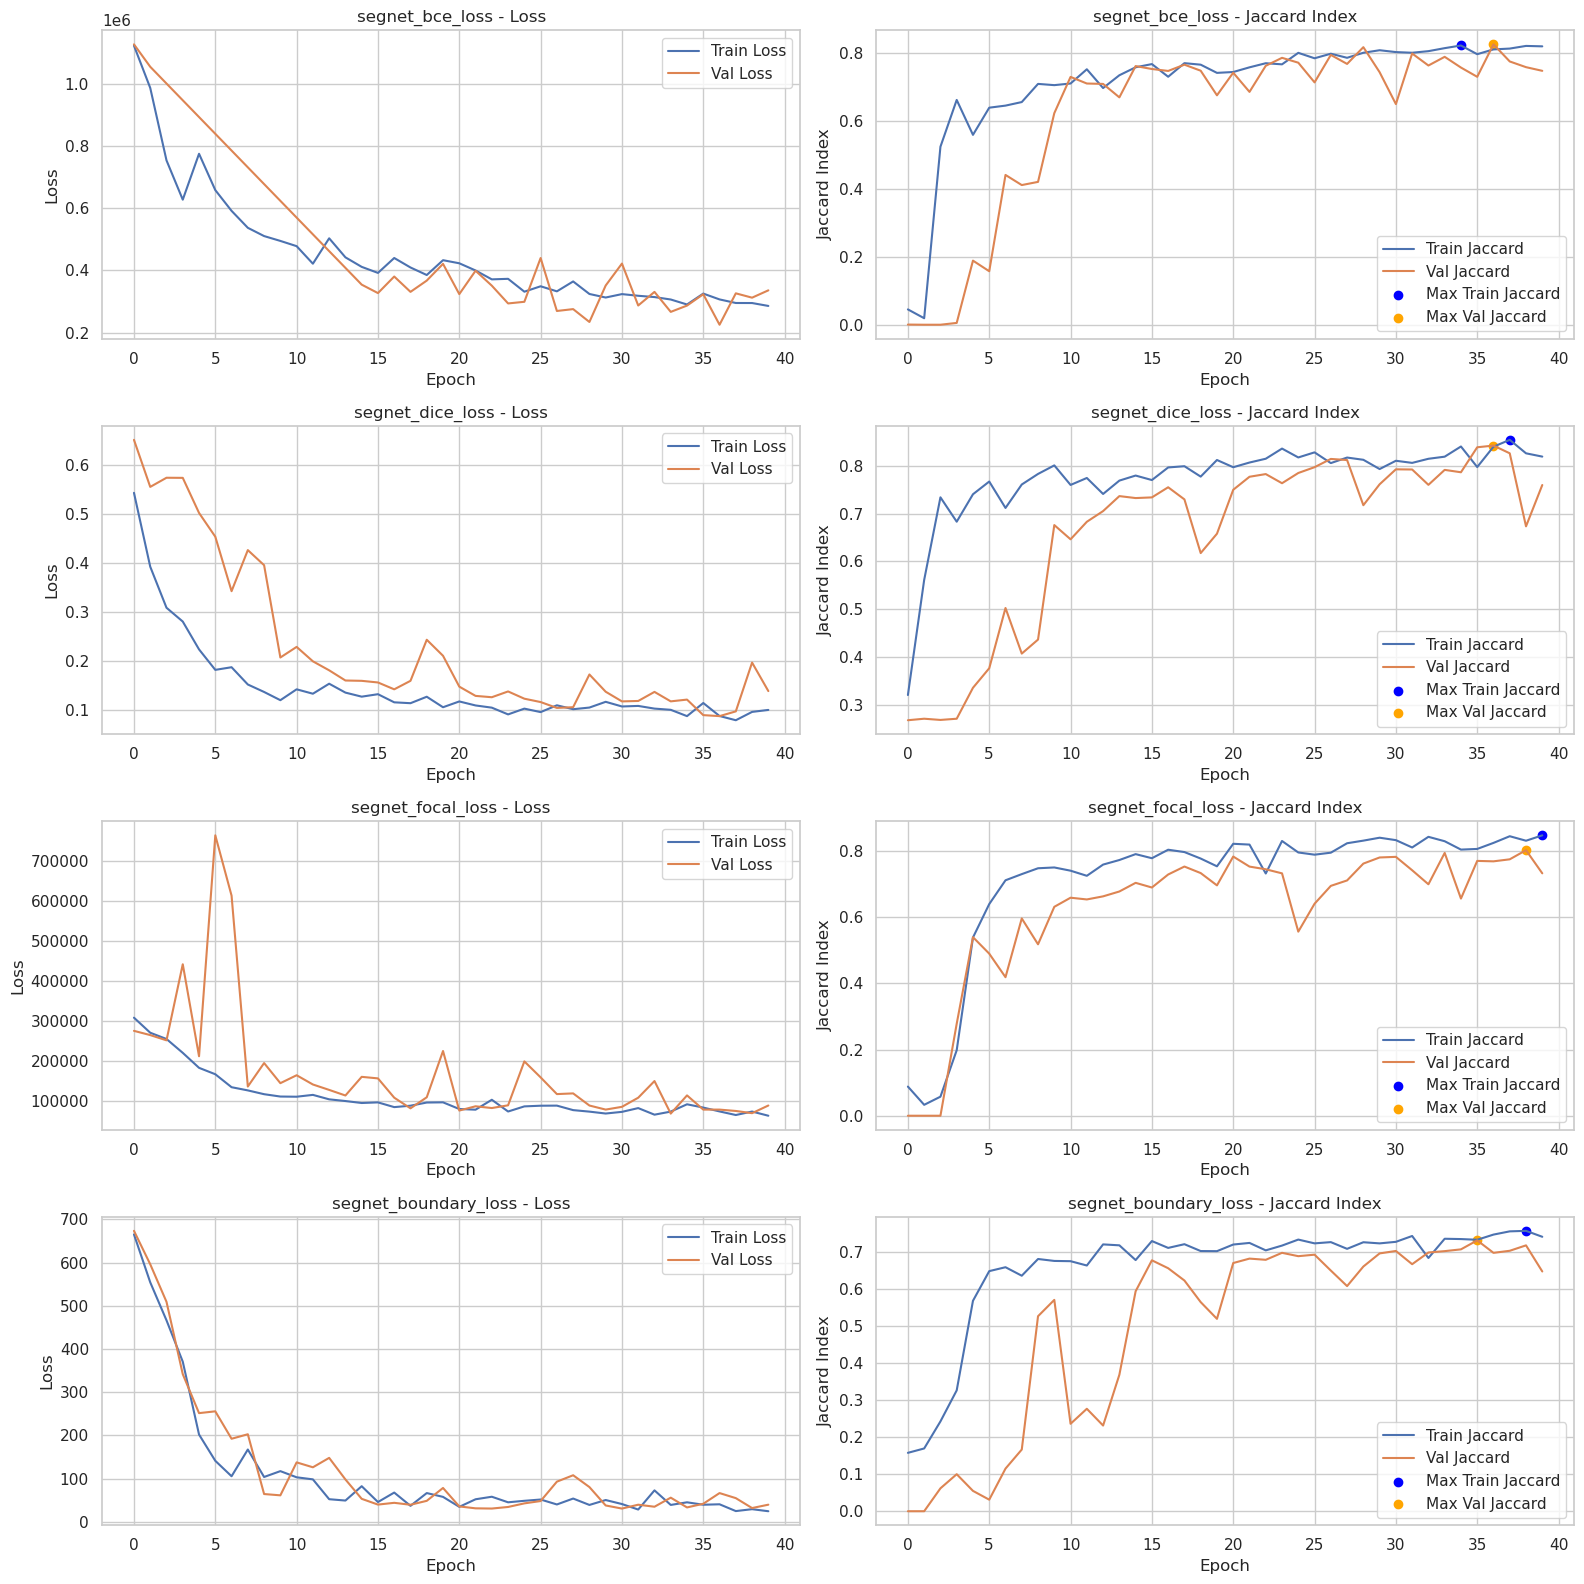

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Данные
results = {
    "segnet_bce_loss": segnet_bce_loss_train_results,
    "segnet_dice_loss": segnet_dice_loss_train_results,
    "segnet_focal_loss": segnet_focal_loss_train_results,
    "segnet_boundary_loss": segnet_boundary_loss_train_results,
}

# Создаем фигуру
fig, axes = plt.subplots(4, 2, figsize=(16, 16))
sns.set_theme(style="whitegrid")

for i, (key, data) in enumerate(results.items()):
    # Loss график
    sns.lineplot(
        x=np.arange(len(data["train_loss"])),
        y=data["train_loss"],
        ax=axes[i, 0],
        label="Train Loss"
    )
    sns.lineplot(
        x=np.arange(len(data["val_loss"])),
        y=data["val_loss"],
        ax=axes[i, 0],
        label="Val Loss"
    )
    axes[i, 0].set_title(f"{key} - Loss")
    axes[i, 0].set_xlabel("Epoch")
    axes[i, 0].set_ylabel("Loss")
    axes[i, 0].legend()

    # Jaccard график
    sns.lineplot(
        x=np.arange(len(data["train_jaccard"])),
        y=data["train_jaccard"],
        ax=axes[i, 1],
        label="Train Jaccard"
    )
    sns.lineplot(
        x=np.arange(len(data["val_jaccard"])),
        y=data["val_jaccard"],
        ax=axes[i, 1],
        label="Val Jaccard"
    )

    # Максимумы Jaccard
    max_train_idx = np.argmax(data["train_jaccard"])
    max_val_idx = np.argmax(data["val_jaccard"])
    axes[i, 1].scatter(
        max_train_idx, data["train_jaccard"][max_train_idx], color="blue", label="Max Train Jaccard"
    )
    axes[i, 1].scatter(
        max_val_idx, data["val_jaccard"][max_val_idx], color="orange", label="Max Val Jaccard"
    )
    axes[i, 1].set_title(f"{key} - Jaccard Index")
    axes[i, 1].set_xlabel("Epoch")
    axes[i, 1].set_ylabel("Jaccard Index")
    axes[i, 1].legend()

plt.tight_layout()
plt.show()

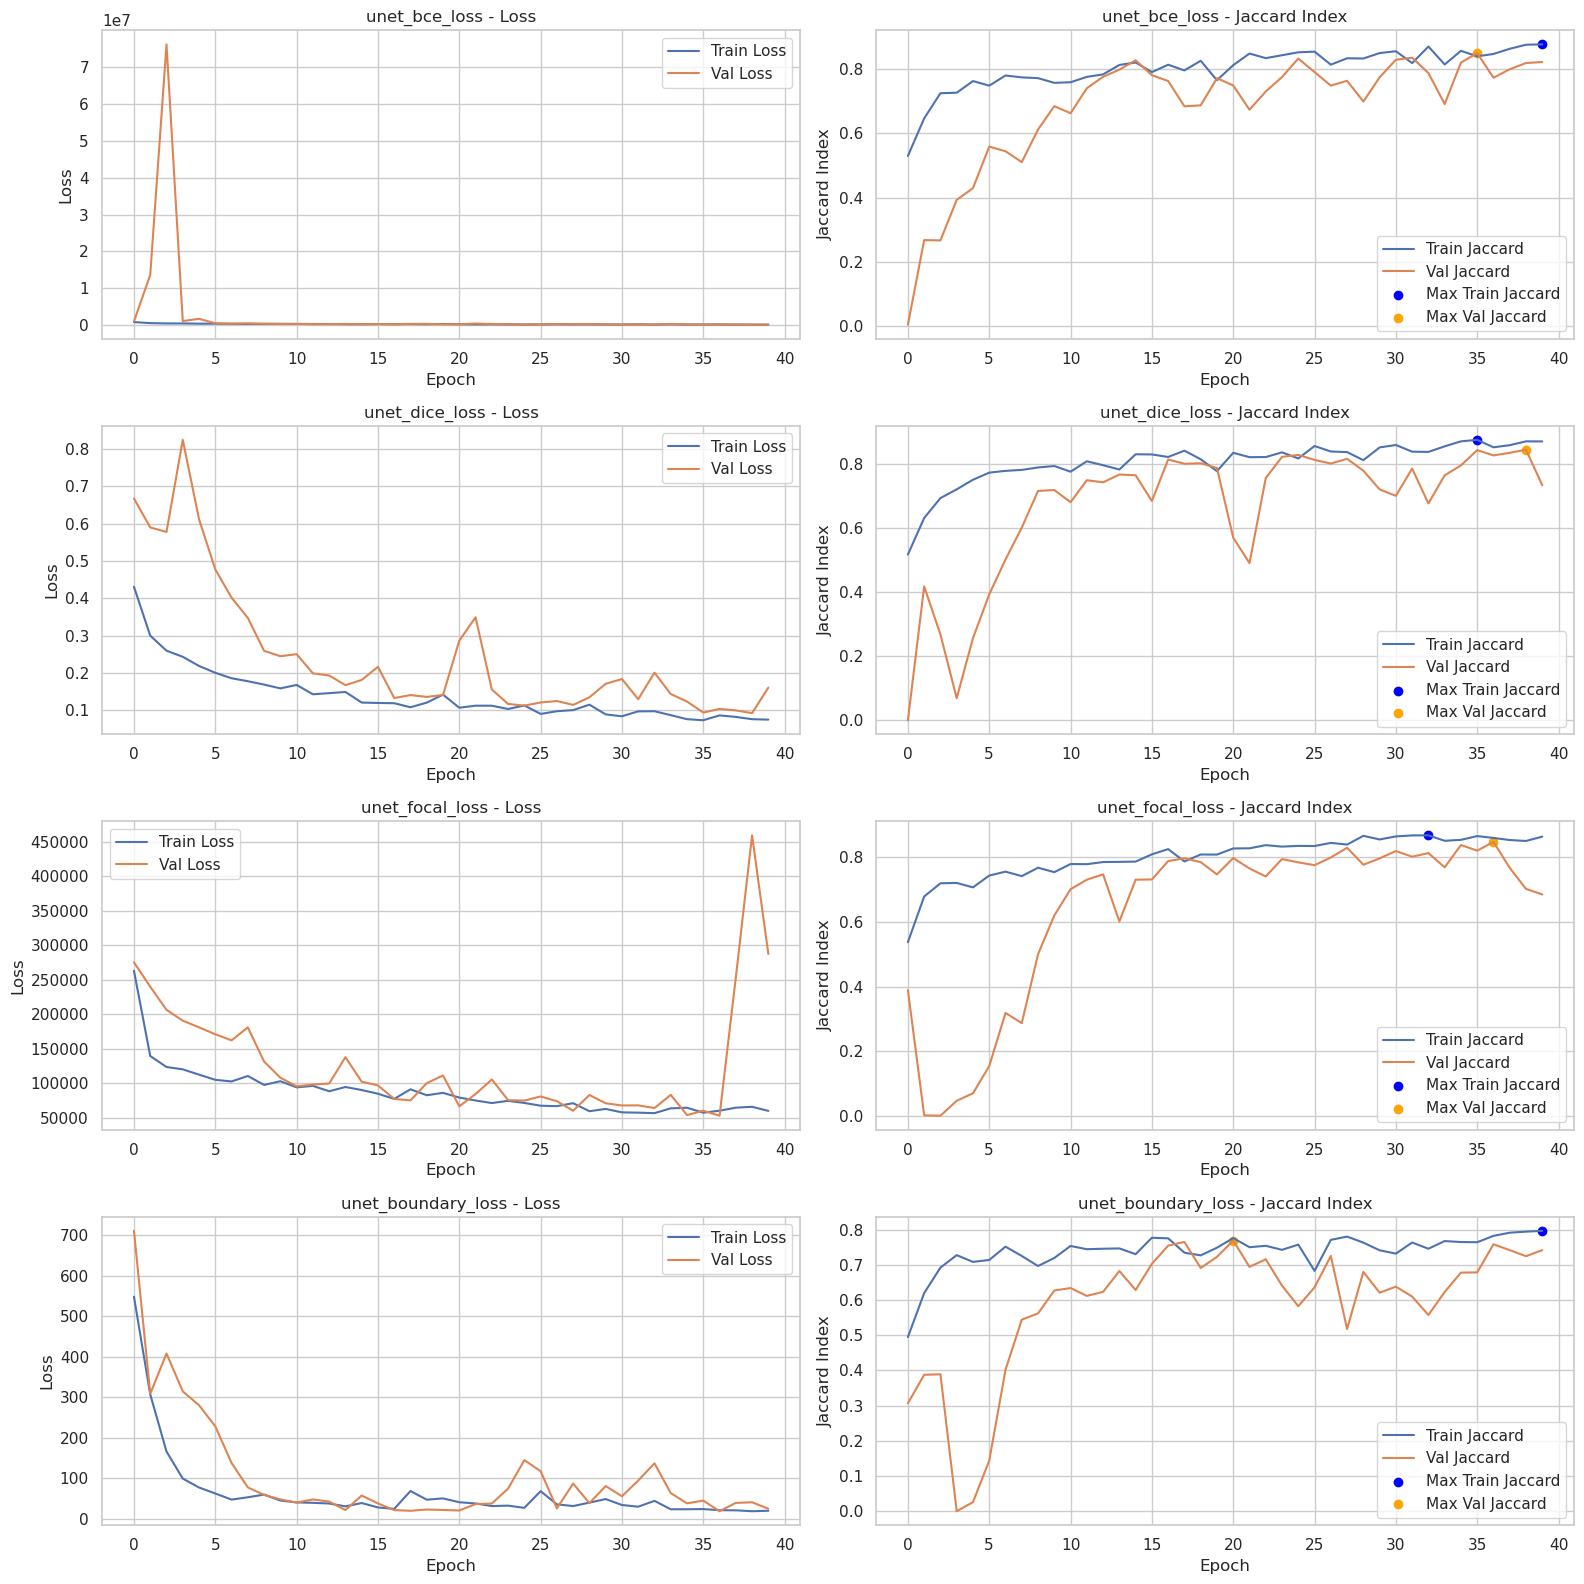

In [84]:
# Данные
results = {
    "unet_bce_loss": unet_bce_loss_train_results,
    "unet_dice_loss": unet_dice_loss_train_results,
    "unet_focal_loss": unet_focal_loss_train_results,
    "unet_boundary_loss": unet_boundary_loss_train_results,
}

# Создаем фигуру
fig, axes = plt.subplots(4, 2, figsize=(16, 16))
sns.set_theme(style="whitegrid")

for i, (key, data) in enumerate(results.items()):
    # Loss график
    sns.lineplot(
        x=np.arange(len(data["train_loss"])),
        y=data["train_loss"],
        ax=axes[i, 0],
        label="Train Loss"
    )
    sns.lineplot(
        x=np.arange(len(data["val_loss"])),
        y=data["val_loss"],
        ax=axes[i, 0],
        label="Val Loss"
    )
    axes[i, 0].set_title(f"{key} - Loss")
    axes[i, 0].set_xlabel("Epoch")
    axes[i, 0].set_ylabel("Loss")
    axes[i, 0].legend()

    # Jaccard график
    sns.lineplot(
        x=np.arange(len(data["train_jaccard"])),
        y=data["train_jaccard"],
        ax=axes[i, 1],
        label="Train Jaccard"
    )
    sns.lineplot(
        x=np.arange(len(data["val_jaccard"])),
        y=data["val_jaccard"],
        ax=axes[i, 1],
        label="Val Jaccard"
    )

    # Максимумы Jaccard
    max_train_idx = np.argmax(data["train_jaccard"])
    max_val_idx = np.argmax(data["val_jaccard"])
    axes[i, 1].scatter(
        max_train_idx, data["train_jaccard"][max_train_idx], color="blue", label="Max Train Jaccard"
    )
    axes[i, 1].scatter(
        max_val_idx, data["val_jaccard"][max_val_idx], color="orange", label="Max Val Jaccard"
    )
    axes[i, 1].set_title(f"{key} - Jaccard Index")
    axes[i, 1].set_xlabel("Epoch")
    axes[i, 1].set_ylabel("Jaccard Index")
    axes[i, 1].legend()

plt.tight_layout()
plt.show()

# Случайно отображаем полученные маски, для лучшей модели

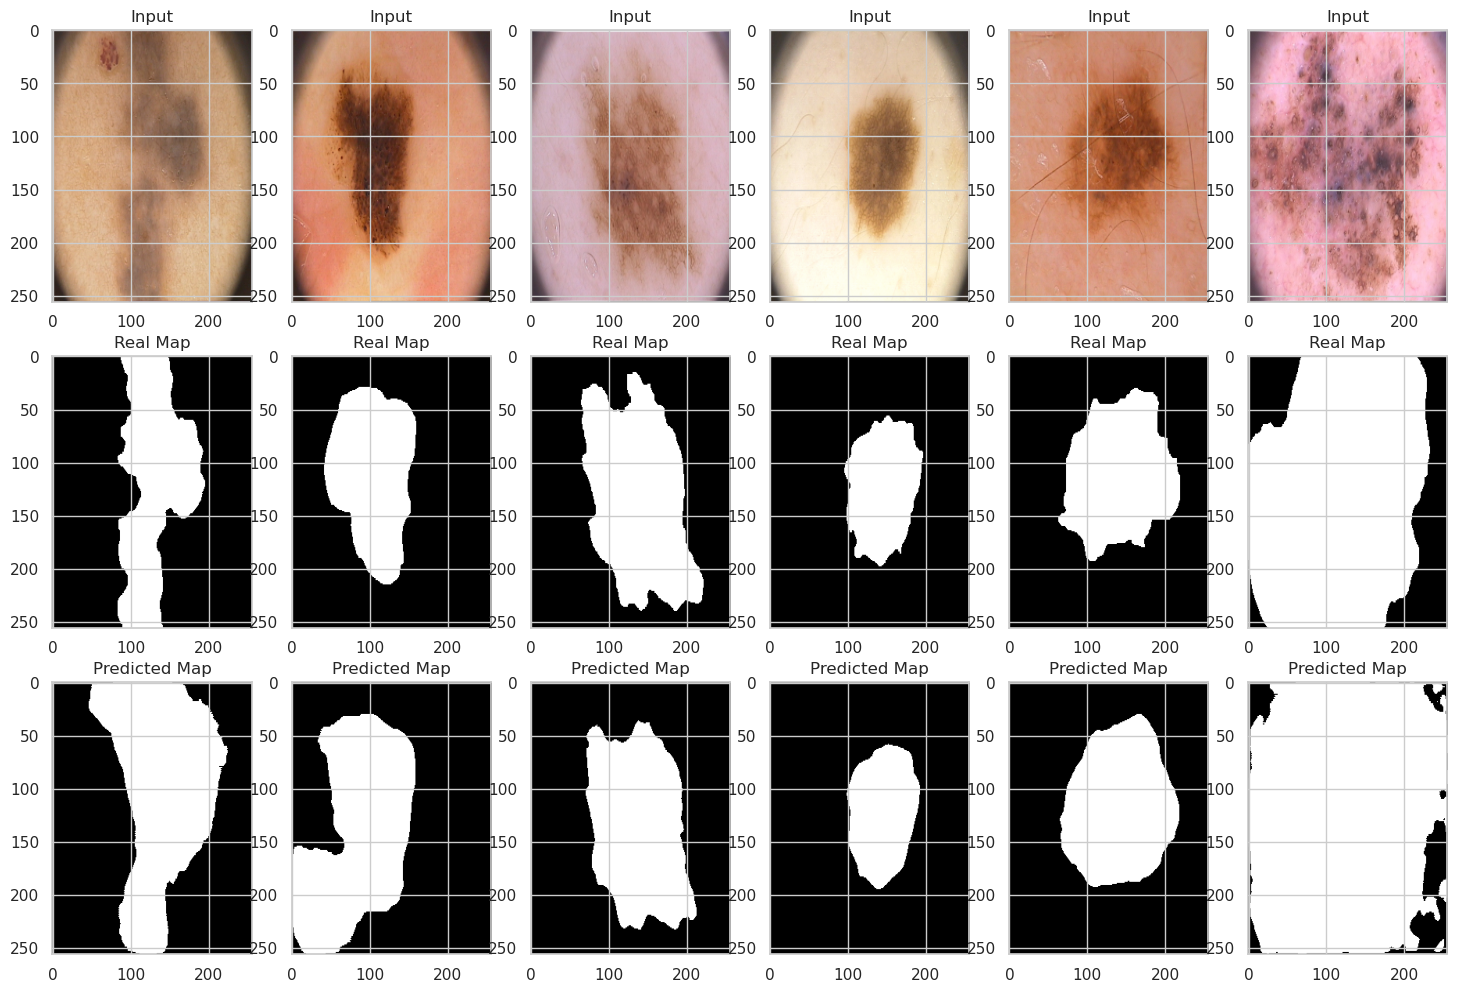

In [90]:
# Загрузка лучшего чекпоинта модели
best_model = UNet().to(device)
# Загрузка весов
best_model.load_state_dict(torch.load("u_net_model_bce_loss.pth"))

show_random_images(best_model, test_dataloader, device)